In [4]:
pip install gplearn

In [5]:
#Imports
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics, tree
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [6]:


import numpy as np
import pandas as pd

def generate_special_quintics(n_samples=1000, a_range=(-10, 10), b_range=(-10, 10), seed=42):
    np.random.seed(seed)
    a_vals = np.random.uniform(*a_range, size=n_samples)
    b_vals = np.random.uniform(*b_range, size=n_samples)

    data = []

    for a, b in zip(a_vals, b_vals):
        # Construct polynomial: f(x) = x(x^2 + ax + b)^2
        # Expand (x^2 + ax + b)^2
        # (x^2 + ax + b)^2 = x^4 + 2a x^3 + (a^2 + 2b)x^2 + 2ab x + b^2
        # Multiply by x: final form
        coeffs = [
            1,             # x^5
            2*a,           # x^4
            a**2 + 2*b,    # x^3
            2*a*b,         # x^2
            b**2,          # x^1
            0              # constant term
        ]

        # Discriminant of the inner quadratic
        disc = a**2 - 4*b
        label = int(disc < 0)  # 1 if complex roots exist, 0 if not

        data.append([a, b, *coeffs, label])

    columns = ['a', 'b', 'c5', 'c4', 'c3', 'c2', 'c1', 'c0', 'has_complex']
    return pd.DataFrame(data, columns=columns)
data = generate_special_quintics(n_samples=40000)


# Step 2: Split dataset
X = data[['a', 'b']]
y = data['has_complex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM with Poly kernel
svmModel = SVC(kernel='poly', degree = 5, C =1)
svmModel.fit(X_train, y_train)
y_pred = svmModel.predict(X_test)

# Get probability predictions - make sure we handle the case if they're not available
try:
    y_prob = svmModel.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
except (AttributeError, TypeError):
    y_prob = None
    auc = None

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
#Removed cross validation due to long computing time, add back in later maybe....
results = []
results.append(['SVM', acc, precision, recall, specificity, f1, auc])

# Create DataFrame for results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score", "AUC"])
print(results_df)

  Model  Accuracy  Precision    Recall  Specificity  F1 Score   AUC
0   SVM  0.854125   0.837327  0.390129     0.979517  0.532265  None


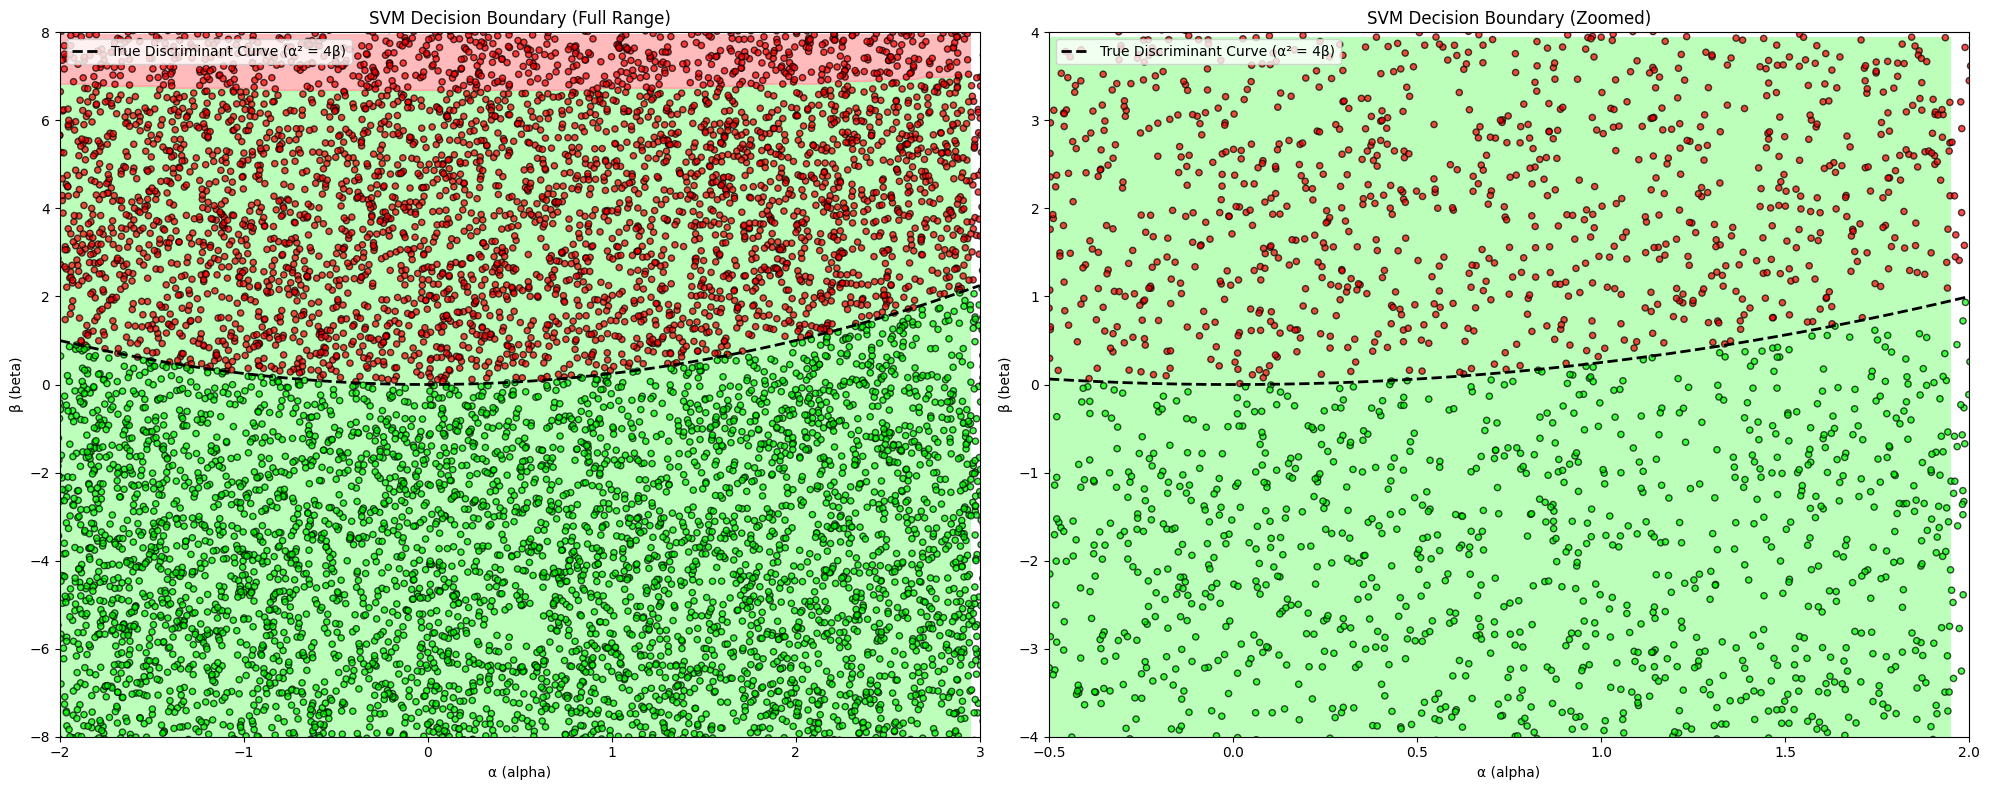

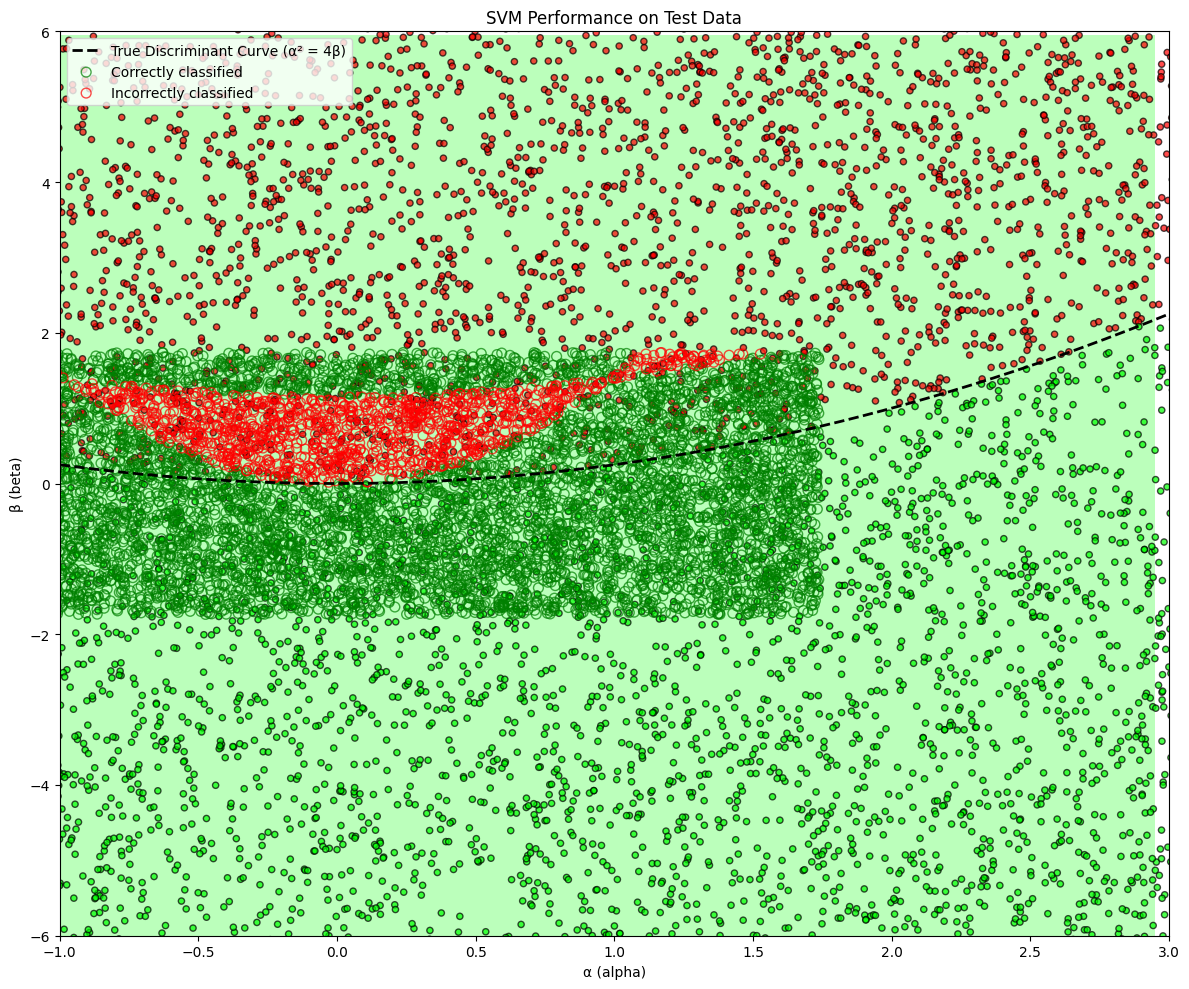

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


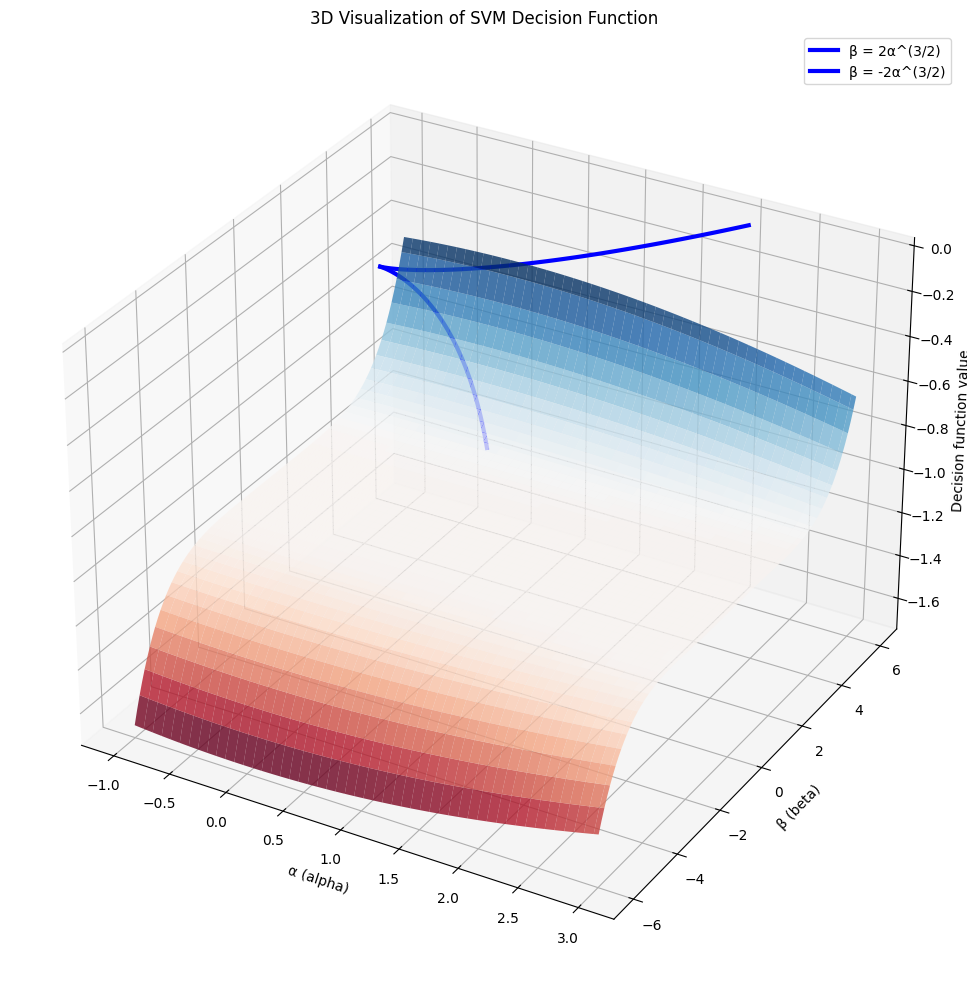


Model Performance Summary:
Accuracy: 0.8541
Precision: 0.8373
Recall: 0.3901
Specificity: 0.9795
F1 Score: 0.5323
AUC: Not available


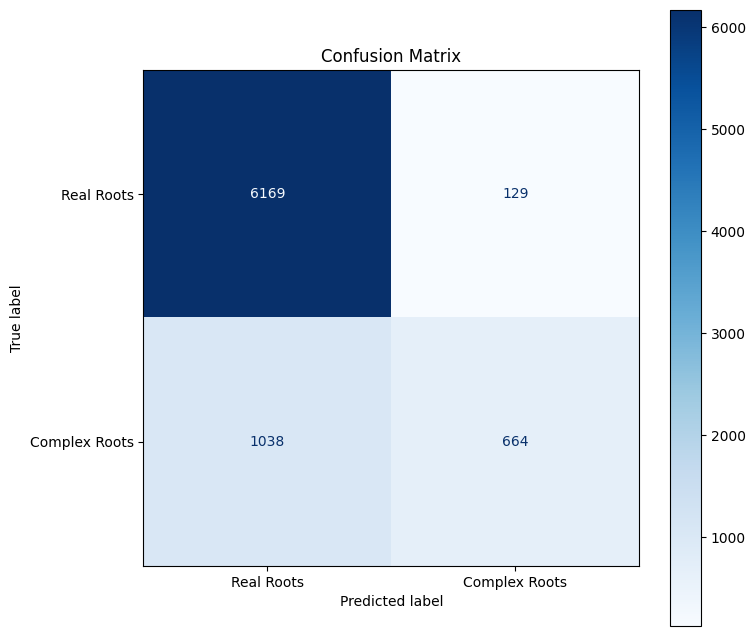

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_true_polynomial_curve(ax, alpha_range):
    """Plots the true polynomial curve (discriminant = 0) on the given axes."""
    alpha_values = np.linspace(alpha_range[0], alpha_range[1], 1000)
    beta_values = (alpha_values**2) / 4  # β = α² / 4 for discriminant = 0
    ax.plot(alpha_values, beta_values, 'k--', label='True Discriminant Curve (α² = 4β)', linewidth=2)

def plot_decision_boundary(X, y, model, scaler, ax=None, title=None, alpha_range=(-2, 3), beta_range=(-8, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    h = 0.05
    x_min, x_max = alpha_range
    y_min, y_max = beta_range

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Try to match column names if using a scaler trained on a DataFrame
    try:
        mesh_df = pd.DataFrame(mesh_points, columns=X.columns)
        mesh_points_scaled = scaler.transform(mesh_df)
    except:
        mesh_points_scaled = scaler.transform(mesh_points)

    Z = model.predict(mesh_points_scaled)
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#AAFFAA', '#FFAAAA'])
    cmap_bold = ListedColormap(['#00FF00', '#FF0000'])

    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, s=20, edgecolors='k', alpha=0.7)

    ax.set_xlabel('α (alpha)')
    ax.set_ylabel('β (beta)')
    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    return ax

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: SVM decision boundary with full dataset
plot_decision_boundary(X, y, svmModel, scaler, ax=axes[0],
                      title='SVM Decision Boundary (Full Range)',
                      alpha_range=(-2, 3), beta_range=(-8, 8))
plot_true_polynomial_curve(ax=axes[0], alpha_range=(-2, 3))
axes[0].legend(loc='upper left')

# Plot 2: Zoomed in view focused on the boundary region
plot_decision_boundary(X, y, svmModel, scaler, ax=axes[1],
                      title='SVM Decision Boundary (Zoomed)',
                      alpha_range=(-0.5, 2), beta_range=(-4, 4))
plot_true_polynomial_curve(ax=axes[1], alpha_range=(-0.5, 2))
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.savefig('svm_polynomial_boundary.png', dpi=300)
plt.show()

# Add a more detailed visualization showing test points and their predictions
fig, ax = plt.subplots(figsize=(12, 10))

# Plot decision boundary
plot_decision_boundary(X, y, svmModel, scaler, ax=ax,
                      title='SVM Performance on Test Data',
                      alpha_range=(-1, 3), beta_range=(-6, 6))
plot_true_polynomial_curve(ax=ax, alpha_range=(-1, 3))

# Highlight test points with wrong predictions
X_test_orig = X_test  # Original (unscaled) test points
wrong_predictions = (y_pred != y_test)
correct_predictions = ~wrong_predictions

# Plot correctly classified points
ax.scatter(X_test_orig[correct_predictions, 0], X_test_orig[correct_predictions, 1],
           s=50, linewidth=1, facecolors='none', edgecolors='green', alpha=0.7,
           label='Correctly classified')

# Plot incorrectly classified points
ax.scatter(X_test_orig[wrong_predictions, 0], X_test_orig[wrong_predictions, 1],
           s=50, linewidth=1, facecolors='none', edgecolors='red', alpha=0.7,
           label='Incorrectly classified')

ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('svm_test_performance.png', dpi=300)
plt.show()

# Create a 3D visualization of the decision function
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid
x_min, x_max = -1, 3  # alpha range
y_min, y_max = -6, 6  # beta range
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Scale the mesh points
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_points_scaled = scaler.transform(mesh_points)

# Get decision function values
Z = svmModel.decision_function(mesh_points_scaled)
Z = Z.reshape(xx.shape)

# Plot the surface
surf = ax.plot_surface(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)

# Mark the zero decision boundary with a contour
ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='-')

# Plot true polynomial curves
alpha_values = np.linspace(0, x_max, 100)
upper_curve = 2 * alpha_values**(3/2)
lower_curve = -2 * alpha_values**(3/2)

# Create mask for valid values within range
upper_mask = (alpha_values >= x_min) & (upper_curve <= y_max) & (upper_curve >= y_min)
lower_mask = (alpha_values >= x_min) & (lower_curve <= y_max) & (lower_curve >= y_min)

# Plot true boundary curves on the Z=0 plane
ax.plot(alpha_values[upper_mask], upper_curve[upper_mask], np.zeros_like(alpha_values[upper_mask]),
        'b-', linewidth=3, label='β = 2α^(3/2)')
ax.plot(alpha_values[lower_mask], lower_curve[lower_mask], np.zeros_like(alpha_values[lower_mask]),
        'b-', linewidth=3, label='β = -2α^(3/2)')

ax.set_xlabel('α (alpha)')
ax.set_ylabel('β (beta)')
ax.set_zlabel('Decision function value')
ax.set_title('3D Visualization of SVM Decision Function')
ax.legend()

plt.tight_layout()
plt.savefig('svm_decision_function_3d.png', dpi=300)
plt.show()

# Print model performance summary
print("\nModel Performance Summary:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
if auc is not None:
    print(f"AUC: {auc:.4f}")
else:
    print("AUC: Not available")

# Add a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real Roots', 'Complex Roots'])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('svm_confusion_matrix.png', dpi=300)
plt.show()


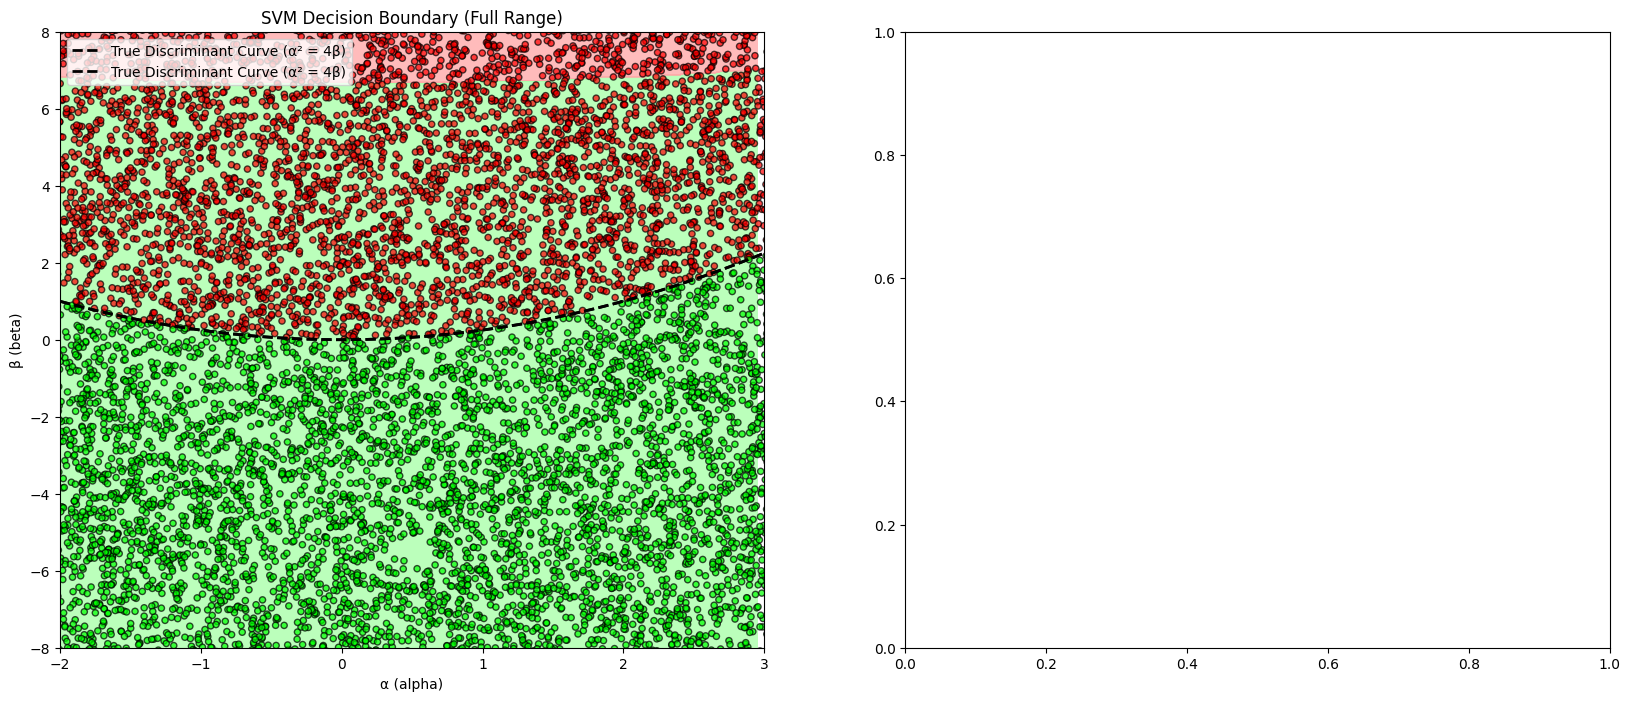

In [9]:
def plot_decision_boundary(X, y, model, scaler, ax=None, title=None, alpha_range=(-2, 3), beta_range=(-8, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    h = 0.05
    x_min, x_max = alpha_range
    y_min, y_max = beta_range

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Optional: match column names if using a scaler trained on a DataFrame
    try:
        mesh_df = pd.DataFrame(mesh_points, columns=X.columns)
        mesh_points_scaled = scaler.transform(mesh_df)
    except:
        mesh_points_scaled = scaler.transform(mesh_points)

    Z = model.predict(mesh_points_scaled)
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#AAFFAA', '#FFAAAA'])
    cmap_bold = ListedColormap(['#00FF00', '#FF0000'])

    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, s=20, edgecolors='k', alpha=0.7)

    # Plot the true discriminant curve: β = α² / 4
    alpha_vals = np.linspace(x_min, x_max, 1000)
    beta_vals = (alpha_vals**2) / 4
    ax.plot(alpha_vals, beta_vals, 'k--', label='True Discriminant Curve (α² = 4β)', linewidth=2)

    ax.set_xlabel('α (alpha)')
    ax.set_ylabel('β (beta)')
    if title:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()

    return ax


# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: SVM decision boundary with full dataset
plot_decision_boundary(X, y, svmModel, scaler, ax=axes[0],
                      title='SVM Decision Boundary (Full Range)',
                      alpha_range=(-2, 3), beta_range=(-8, 8))
plot_true_polynomial_curve(ax=axes[0], alpha_range=(-2, 3))
axes[0].legend(loc='upper left')


In [10]:
from gplearn.genetic import SymbolicClassifier
from gplearn.functions import make_function
from sklearn.metrics import classification_report

from gplearn.genetic import SymbolicClassifier

# Patch to add __sklearn_tags__ method
def __sklearn_tags__(self):
    return {
        "non_deterministic": True,
        "requires_y": True,
        "poor_score": True,
        "X_types": ["2darray"],
    }

SymbolicClassifier.__sklearn_tags__ = __sklearn_tags__

# Train symbolic regression model
sym_clf = SymbolicClassifier(population_size=1000,
                             generations=20,
                             stopping_criteria=0.01,
                             p_crossover=0.7,
                             p_subtree_mutation=0.1,
                             p_hoist_mutation=0.05,
                             p_point_mutation=0.1,
                             max_samples=0.9,
                             verbose=1,
                             parsimony_coefficient=0.001,
                             random_state=42)

sym_clf.fit(X_train, y_train)

# Predictions and performance
y_pred_sym = sym_clf.predict(X_test)
print("\nSymbolic Regression Classification Report:")
print(classification_report(y_test, y_pred_sym))

# Print discovered formula
print("Learned symbolic expression:")
print(sym_clf._program)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    36.26           3.0256        9         0.301632         0.305111      2.64m
   1    14.37          1.02779        7          0.26557         0.272114      2.27m
   2    14.24         0.848735       35         0.181994         0.170051      1.91m
   3    17.97         0.707282       37         0.156893         0.158442      2.00m
   4    20.03         0.574904       63        0.0831463        0.0848405      1.98m
   5    25.08         0.465955       67         0.079985        0.0794566      1.66m
   6    31.72         0.435568       47        0.0613206         0.059333      1.63m
   7    30.97         0.396259       77        0.0469092        0.0498375      1.29m
   8    34.60         0.370531       81        0.0309146        0.0304153  

In [11]:
import sympy as sp

# Define symbolic variables
alpha, beta = sp.symbols('alpha beta')

# Define math functions for eval
def add(a, b): return a + b
def sub(a, b): return a - b
def mul(a, b): return a * b
def div(a, b): return a / b

# Raw symbolic regression output (as string!)
symbolic_raw_output = """
add(add(X1, add(X1, sub(add(X1, sub(X1, mul(add(X0, X0), X0))), mul(add(X0, X0), X0)))), div(add(X1, sub(add(X1, sub(add(X1, div(add(X1, sub(add(X1, sub(sub(add(X1, add(X1, add(X1, sub(sub(add(X1, sub(X1, mul(add(X0, X0), X0))), mul(add(X0, X0), X0)), mul(add(X0, X0), X0))))), mul(add(X0, X0), X0)), mul(add(X0, X0), X0))), mul(X0, X0))), 0.274)), mul(add(X0, X0), X0))), mul(X0, X0))), mul(X0, X0)))
"""

# Replace X0, X1 with alpha, beta
symbolic_raw_output = symbolic_raw_output.replace('X0', 'alpha').replace('X1', 'beta')

# Evaluate the expression safely
expr = eval(symbolic_raw_output, {
    'alpha': alpha,
    'beta': beta,
    'add': add,
    'sub': sub,
    'mul': mul,
    'div': div
})

# Simplify
simplified = sp.simplify(expr)

# Display
print(" Simplified Symbolic Expression:")
sp.pprint(simplified, use_unicode=True)

 Simplified Symbolic Expression:
     2                            28.5474452554745⋅β
- 4⋅α  + 4⋅β - 43.1459854014598 + ──────────────────
                                           2        
                                          α         


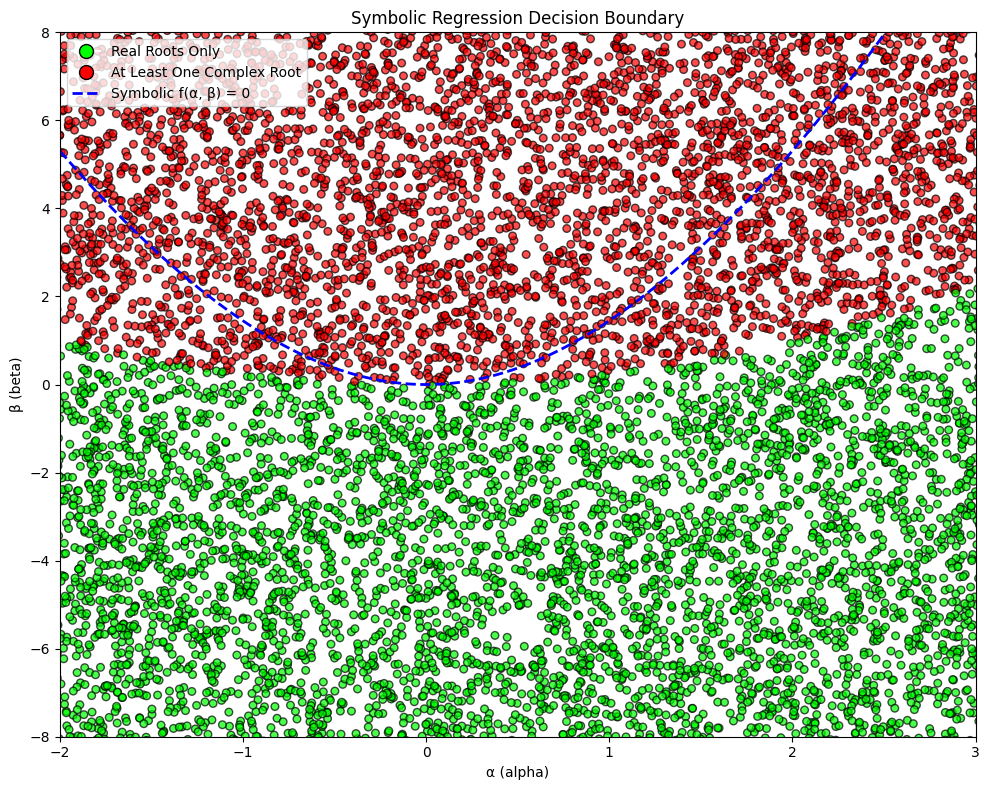

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import sympy as sp

# Define symbolic variables and math operations
alpha, beta = sp.symbols('alpha beta')

# Assuming `simplified` is your symbolic expression from earlier:
# If not, define it manually here
# Example: simplified = sp.sympify("beta - 2*alpha**(3/2)")

# Create a lambdified version of the symbolic expression
f_expr = sp.lambdify((alpha, beta), simplified, modules='numpy')

# Rename your X dataframe columns for clarity
X.columns = ['alpha', 'beta']

# Create a grid over the (alpha, beta) space
alpha_vals = np.linspace(-2, 3, 400)
beta_vals = np.linspace(-8, 8, 400)
A, B = np.meshgrid(alpha_vals, beta_vals)

# Evaluate the symbolic expression on the grid
Z = f_expr(A, B)

# Plot the dataset with the symbolic regression boundary
fig, ax = plt.subplots(figsize=(10, 8))

# Colormap for decision classes
cmap_bold = ListedColormap(['#00FF00', '#FF0000'])

# Scatter plot of data points
scatter = ax.scatter(X['alpha'], X['beta'], c=y, cmap=cmap_bold,
                     s=30, edgecolors='k', alpha=0.7)

# Plot the symbolic regression decision boundary: f(α, β) = 0
contour = ax.contour(A, B, Z, levels=[0], colors='blue', linewidths=2, linestyles='--')

# Create proxy artist for the decision boundary in the legend
proxy_line = Line2D([0], [0], linestyle='--', color='blue', linewidth=2)

#Create color legend manually
green_dot = Line2D([0], [0], marker='o', color='w', label='Real Roots Only',
                   markerfacecolor='#00FF00', markersize=10, markeredgecolor='k')
red_dot = Line2D([0], [0], marker='o', color='w', label='At Least One Complex Root',
                 markerfacecolor='#FF0000', markersize=10, markeredgecolor='k')


# Add legend with proxy artist and data points
ax.legend([green_dot, red_dot, proxy_line],
          ['Real Roots Only', 'At Least One Complex Root', 'Symbolic f(α, β) = 0'],
          loc='upper left')

# Add labels and styling
ax.set_xlabel('α (alpha)')
ax.set_ylabel('β (beta)')
ax.set_title('Symbolic Regression Decision Boundary')
ax.set_xlim(-2, 3)
ax.set_ylim(-8, 8)

plt.tight_layout()
plt.savefig('symbolic_regression_boundary.png', dpi=300)
plt.show()

 Symbolic Classifier Accuracy: 0.8800


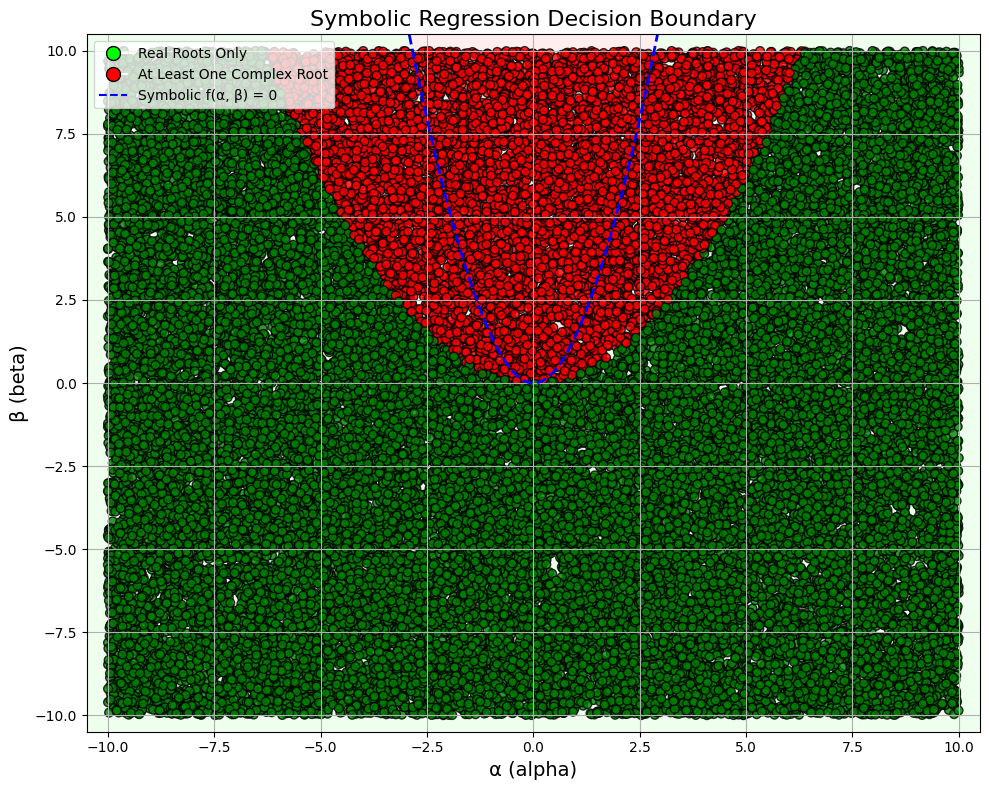

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

# Step 1: Apply symbolic function to your dataset
f_values = f_expr(X['alpha'].values, X['beta'].values)
symbolic_preds = (f_values > 0).astype(int)

# Step 2: Evaluate accuracy
accuracy = accuracy_score(y, symbolic_preds)
print(f" Symbolic Classifier Accuracy: {accuracy:.4f}")

# Step 3: Plot decision regions and symbolic boundary
alpha_vals = np.linspace(X['alpha'].min() - 0.5, X['alpha'].max() + 0.5, 400)
beta_vals = np.linspace(X['beta'].min() - 0.5, X['beta'].max() + 0.5, 400)
A, B = np.meshgrid(alpha_vals, beta_vals)
Z = f_expr(A, B)

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Region background color based on symbolic prediction
cmap_light = ListedColormap(['#AAFFAA', '#FFAAAA'])  # green for real, red for complex
ax.contourf(A, B, Z > 0, alpha=0.2, cmap=cmap_light)

# Scatter plot of true data
scatter = ax.scatter(X['alpha'], X['beta'], c=y, cmap=ListedColormap(['green', 'red']),
                     edgecolors='k', s=40, alpha=0.8, label='Data')

# Symbolic decision boundary: f(alpha, beta) = 0
contour = ax.contour(A, B, Z, levels=[0], colors='blue', linewidths=2, linestyles='--')
proxy_line = plt.Line2D([0], [0], linestyle='--', color='blue', label='Symbolic f(α,β)=0')

# Labels and legend
ax.set_xlabel('α (alpha)', fontsize=14)
ax.set_ylabel('β (beta)', fontsize=14)
ax.set_title('Symbolic Regression Decision Boundary', fontsize=16)

ax.legend([green_dot, red_dot, proxy_line],
          ['Real Roots Only', 'At Least One Complex Root', 'Symbolic f(α, β) = 0'],
          loc='upper left')


ax.set_xlim(alpha_vals.min(), alpha_vals.max())
ax.set_ylim(beta_vals.min(), beta_vals.max())
plt.grid(True)
plt.tight_layout()
plt.show()